## Sistema de monitoreo de los bosques de Bogotá 

In [33]:
import os
import sys
#import wbdata
import datetime
import geopandas as gpd

#Se importan todos los archivos necesarios para hacer mapas
from metodos_mixtos import mapas
from metodos_mixtos import mapas_raster

import folium
import rasterio
import numpy as np
import shapely.geometry as sg

ModuleNotFoundError: No module named 'osgeo'

In [2]:
#Crear el diccionario de rutas
programacion_path = '/Users/Daniel/Library/CloudStorage/OneDrive-VestigiumMétodosMixtosAplicadosSAS/Programacion'
geoinfo_path = '/Users/Daniel/Library/CloudStorage/OneDrive-VestigiumMétodosMixtosAplicadosSAS/geoinfo'

rutas = mapas.diccionario_rutas(programacion_path, geoinfo_path)

In [3]:
#La información está en Teams en en el canal GIS en
#data_folder = 'geoinfo/Colombia/Bogotá/bosques_bogota'
#https://metodosmixtos.sharepoint.com/:f:/s/MMC-General/EogKVdk7FYZBsTKCr79IK98BgnozkrY1czyiyR6MDn5i5g?e=uTfrIK

ruta_externa = 'geoinfo/Colombia/Bogotá/bosques_bogota'

###  Cargar los shapes

In [36]:
#Todos lso municipios de colombia
mpios = gpd.read_file(rutas['mpios'])

#Shape de Bogotá
bta = mpios[mpios['MPIO_CDPMP'] == '11001']

#Cargar el shape de macroterritorio rurales 
mtr = gpd.read_file(ruta_externa+'macroterritorio_rural/Macroterritorio_Rural.shp')

#Unidades de planeamiento local de Bogotá
upls_path = ruta_externa+'unidadplaneamientolocal/UnidadPlaneamientoLocal.shp'
upls = gpd.read_file(upls_path)

#Solo las UPLs con clasificación rural o urbano-rural
upls_semi_rurales = upls[upls['VOCACION'].isin(['Urbano-Rural', 'Rural'])]

#Solo las UPLs clasificadas como rurales
upls_rurales = upls[upls['VOCACION'].isin(['Rural'])]

#Excluir las UPLs de Sumapáz y de Cuenta del Tunjuelo para mejor visualización
bta_compacta = upls[~upls['CODIGO_UPL'].isin(['UPL01','UPL02'])]

In [4]:
#Obtener un shape con Bogotá y todos los municipios aledaños
def get_adjoining_polygons(gdf1, gdf2):
    """
    Returns a GeoDataFrame with polygons from gdf1 that adjoin gdf2.

    Parameters:
    - gdf1: GeoDataFrame containing the polygons to check for adjacency.
    - gdf2: GeoDataFrame containing the polygons to check adjacency against.

    Returns:
    - adjoining_gdf: GeoDataFrame containing polygons from gdf1 that adjoin gdf2.
    """
    # Ensure the GeoDataFrames use the same coordinate reference system (CRS)
    if gdf1.crs != gdf2.crs:
        gdf2 = gdf2.to_crs(gdf1.crs)
    
    # Create an empty list to hold indices of gdf1 polygons that adjoin gdf2
    adjoining_indices = []

    # Iterate over each polygon in gdf1
    for index, poly1 in gdf1.iterrows():
        # Check if the polygon touches any polygon in gdf2
        if gdf2.geometry.touches(poly1.geometry).any():
            adjoining_indices.append(index)
    
    # Extract the adjoining polygons from gdf1 using the identified indices
    adjoining_gdf = gdf1.loc[adjoining_indices]

    return adjoining_gdf

In [5]:
#Shape para Bogotá región (todos los municipios que tocan a Bogotá
btr = pd.concat([bta, get_adjoining_polygons(mpios, bta)])

bbox = btr.total_bounds #Bounding box para la región

### Donwload Hansen raster from Google Earth

- Lo datos se  bajan manualmente de GEE para poder guardar el archivo directamente Google Drive. 
- La información se descarga con este código en GEE code editor: 

```javascript
// Define the area of interest (AOI) with the provided bounding box coordinates
var aoi = ee.Geometry.Rectangle([-74.93334681, 2.50714324, -73.71197104, 4.97403411]);

// Load the Hansen Global Forest Change dataset (version 2022, release 1.10)
var hansenDataset = ee.Image('UMD/hansen/global_forest_change_2022_v1_10');

// Clip the dataset to the specified AOI
var clippedDataset = hansenDataset.clip(aoi);

// Define export parameters
var exportParams = {
  image: clippedDataset, 
  description: 'Hansen_forest_change_clipped_to_AOI', 
  scale: 30, 
  region: aoi,
  fileFormat: 'GeoTIFF',
  folder: 'GEE_Downloads', // Specify your Google Drive folder name here
  maxPixels: 1e9
};

// Export the clipped dataset to Google Drive
Export.image.toDrive(exportParams);

print('Export initiated, check Tasks tab for progress');


###  Deforestation maps

In [6]:
hansen_path = ruta_externa+'hansen/Hansen_forest_change_clipped_to_bogota_region.tif'

In [7]:
def create_map_with_cumulative_tree_loss(raster_path, base_year=2000, target_year=2020):
    """
    Creates an HTML map displaying tree cover for the year 2000 and cumulative tree loss up to a target year.
    
    Parameters:
    - raster_path: Path to the raster file containing the data.
    - base_year: The base year for the dataset (default is 2000 for the 'treecover2000' band).
    - target_year: The target year up to which to visualize cumulative tree loss.
    """
    # Assuming a mapping of band names to indices after inspecting the raster
    band_mapping = {
        'treecover2000': 1,  # Example: band 1 for tree cover
        'loss': 2,  # Example: band 2 for loss (year of loss encoded)
    }
    
    # Open the raster file
    with rasterio.open(raster_path) as src:
        # Read the tree cover and loss year bands
        tree_cover = src.read(band_mapping['treecover2000'])
        loss_year = src.read(band_mapping['loss'])
        
        # Calculate which pixels in the loss year band indicate loss up to the target year
        loss_up_to_target_year = ((loss_year >= 1) & (loss_year <= (target_year - base_year + 1))).astype(np.uint8) * 255
        print(target_year)
        
        
        # Get the map's center and bounds for display
        bounds = src.bounds
        map_center = [(bounds.top + bounds.bottom) / 2, (bounds.right + bounds.left) / 2]
    
    # Create a folium map centered on the raster
    m = folium.Map(location=map_center, zoom_start=8)
    
    # Add the tree cover layer
    folium.raster_layers.ImageOverlay(
        image=tree_cover,
        bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
        colormap=lambda x: (0, x/255, 0, x/100),  # Adjusted for % tree cover
        name='Tree Cover 2000'
    ).add_to(m)
    
    # Add the cumulative loss layer up to the target year
    folium.raster_layers.ImageOverlay(
        image=loss_up_to_target_year,
        bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
        colormap=lambda x: (1, 0, 0, x),  # Red for loss
        name=f'Cumulative Forest Loss up to {target_year}',
        overlay=True
    ).add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Save the map to an HTML file
    m.save('cumulative_tree_loss_map.html')
    
    print("Map has been saved to 'cumulative_tree_loss_map.html'")

# Example usage:
# create_map_with_cumulative_tree_loss('path_to_your_raster.tif', base_year=2000, target_year=2020)


In [8]:
#create_map_with_cumulative_tree_loss(hansen_path, base_year=2000, target_year=2020)

### Mapas para hacer el video

In [9]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [181]:
def create_png_map_with_boundaries_and_crs_check(raster_path, 
                                                 gdf, 
                                                 names_column, 
                                                 base_year=2000, 
                                                 target_year=2020, 
                                                 output_path='map.png',
                                                basemap=True):
    """
    Creates a PNG map displaying tree cover for the year 2000, cumulative tree loss up to a target year,
    and overlays geospatial boundaries from a GeoDataFrame, ensuring matching CRS. Adds legends and labels for GDF polygons.
    
    Parameters:
    - raster_path: Path to the raster file containing the data.
    - gdf: A GeoDataFrame containing the boundaries to overlay on the map.
    - names_column: The column in the GDF that contains the names of the polygons.
    - base_year: The base year for the dataset (default is 2000 for the 'treecover2000' band).
    - target_year: The target year up to which to visualize cumulative tree loss.
    - output_path: Path to save the output PNG map.
    """
    # Open the raster file
    with rasterio.open(raster_path) as src:
        # Check and match CRS
        raster_crs = src.crs
        if gdf.crs != raster_crs:
            print(f"Reprojecting GDF from {gdf.crs} to {raster_crs}")
            gdf = gdf.to_crs(raster_crs)
        
        # Assuming band 1 is tree cover and band 2 is loss (year of loss encoded)
        tree_cover = src.read(1)
        loss_year = src.read(4)
        
        # Adjusting for the encoding where 1 corresponds to 2001, hence target_year - 2000
        loss_mask = ((loss_year >= 1) & (loss_year <= (target_year - 2000))).astype(np.uint8)*255
        print(target_year)
        
        # Get the extent of the raster
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        
        # Prepare the figure
        fig, ax = plt.subplots(figsize=(10, 8))

        
        # Plot the tree cover
        tree_cover_layer = ax.imshow(tree_cover, cmap='Greens', extent=extent)
        
        # Overlay the loss mask
        loss_layer = ax.imshow(loss_mask, cmap='Reds', extent=extent, alpha=0.6)
        
        # Overlay the GeoDataFrame boundaries and labels
        gdf.boundary.plot(ax=ax, color='grey', linewidth=1, alpha=0.5)
        for idx, row in gdf.iterrows():
            ax.annotate(text=row[names_column], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=5, color='grey')
        
        # Create legends
        tree_cover_legend = mpatches.Patch(color='green', label=f'Bosque en {target_year}')
        loss_legend = mpatches.Patch(color='red', label=f'Pérdida')
        plt.legend(handles=[tree_cover_legend, loss_legend], loc='lower left')
        
        
        # Adding the OSM background with contextily
        if basemap == True: 
            ctx.add_basemap(ax, crs=raster_crs, source=ctx.providers.CartoDB.Positron, alpha=0.35)
        
        # Set the title and axes labels
        ax.set_title(f'Pérdida de bosque 2000 - {target_year}')
        
        # Remove x and y ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Save the figure
        plt.savefig(output_path, bbox_inches='tight', dpi=400)
        plt.close()
        
        #print(f"Map has been saved to '{output_path}'")


In [182]:
#Crear Torca com shape
trca = upls[upls['NOMBRE'] == 'Torca']

In [194]:
#Cortar el raster de Hansen a las UPLs urbanas para mejor visualización
gdf_path_temporal = ruta_externa+'gdf_temporal/gdf_temporal.shp'
bta_compacta.to_file(gdf_path_temporal)

In [195]:
#Cortar el raster para que quede del tamaño de la Bogotá compacta
clipped_raster_path = ruta_externa+'clipped_raster.tif'
mapas_raster.raster_clipping(gdf_path_temporal, hansen_path, clipped_raster_path)

Reprojecting shapefile from epsg:4686 to EPSG:4326
Cropped raster saved to: /Volumes/MMC HD/bosques_bogota/clipped_raster.tif


'/Volumes/MMC HD/bosques_bogota/clipped_raster.tif'

In [196]:
for year in range(2000,2023):
    
    create_png_map_with_boundaries_and_crs_check(clipped_raster_path, 
                                             bta_compacta, 
                                             names_column='NOMBRE',
                                             base_year=2000,
                                             target_year=year, 
                                             output_path=ruta_externa+'video/bogota/perdida_bogota_{}.png'.format(year))
;

Reprojecting GDF from epsg:4686 to EPSG:4326
2000
Reprojecting GDF from epsg:4686 to EPSG:4326
2001
Reprojecting GDF from epsg:4686 to EPSG:4326
2002
Reprojecting GDF from epsg:4686 to EPSG:4326
2003
Reprojecting GDF from epsg:4686 to EPSG:4326
2004
Reprojecting GDF from epsg:4686 to EPSG:4326
2005
Reprojecting GDF from epsg:4686 to EPSG:4326
2006
Reprojecting GDF from epsg:4686 to EPSG:4326
2007
Reprojecting GDF from epsg:4686 to EPSG:4326
2008
Reprojecting GDF from epsg:4686 to EPSG:4326
2009
Reprojecting GDF from epsg:4686 to EPSG:4326
2010
Reprojecting GDF from epsg:4686 to EPSG:4326
2011
Reprojecting GDF from epsg:4686 to EPSG:4326
2012
Reprojecting GDF from epsg:4686 to EPSG:4326
2013
Reprojecting GDF from epsg:4686 to EPSG:4326
2014
Reprojecting GDF from epsg:4686 to EPSG:4326
2015
Reprojecting GDF from epsg:4686 to EPSG:4326
2016
Reprojecting GDF from epsg:4686 to EPSG:4326
2017
Reprojecting GDF from epsg:4686 to EPSG:4326
2018
Reprojecting GDF from epsg:4686 to EPSG:4326
2019


''

# Create a video with the images of the maps

In [197]:
import os
import moviepy.video.io.ImageSequenceClip

In [198]:
image_folder=ruta_externa+'video/bogota'
fps=2
files = os.listdir(image_folder)
files.sort()
image_files = [image_folder+'/'+img for img in files if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(ruta_externa+'perdida_bosques_bogota.mp4')

Moviepy - Building video /Volumes/MMC HD/bosques_bogota/perdida_bosques_bogota.mp4.
Moviepy - Writing video /Volumes/MMC HD/bosques_bogota/perdida_bosques_bogota.mp4



Moviepy - Done !
Moviepy - video ready /Volumes/MMC HD/bosques_bogota/perdida_bosques_bogota.mp4


### Calcular la evolución de la cobertura boscosa por UPL

In [15]:
#Cortar el raster de Hansen al tamaño de todas las UPLs
upls.to_file(gdf_path_temporal)
mapas_raster.raster_clipping(gdf_path_temporal, hansen_path, clipped_raster_path)

Reprojecting shapefile from epsg:4686 to EPSG:4326
Cropped raster saved to: /Volumes/MMC HD/bosques_bogota/clipped_raster.tif


'/Volumes/MMC HD/bosques_bogota/clipped_raster.tif'

In [16]:
with rasterio.open(hansen_path) as src:
    raster_profile = src.profile  # Store the profile for later use
    #tree_cover_2000 = src.read(1)
    #loss = src.read(3)
    loss_year = src.read(4)

In [17]:
perdida = pd.Series(loss_year.flatten())

<Axes: >

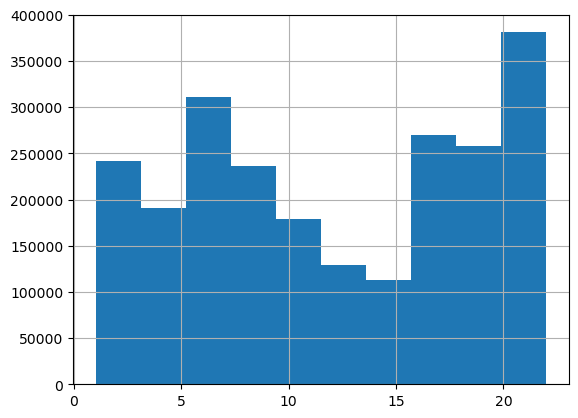

In [18]:
perdida[perdida>0].hist()

In [19]:
df1 = upls.copy(deep=True)

In [20]:
for i in range(2000, 2023):
    df1 = mapas_raster.calculate_tree_cover(clipped_raster_path, df1, i)

In [21]:
df2 = pd.concat([df1[['CODIGO_UPL', 'NOMBRE']], df1.iloc[:,16:]], axis=1)

In [22]:
df2.to_csv(ruta_externa+'cobertura_boscosa_upls_bogota.csv')
df2.to_excel(ruta_externa+'cobertura_boscosa_upls_bogota.xlsx')   

### Análisis de la información

In [23]:
ab_22 = df2['tree_cover_22'].sum()
print(ab_22)

28659.329250000006


In [24]:
ab_00 = df2['tree_cover_0'].sum()
print(ab_00)

29970.02145


In [25]:
ab_00-ab_22

1310.692199999994

In [26]:
#COmparación del áreas
upls[(1250 <  upls['AREA_HA']) &  (upls['AREA_HA'] < 1350)]

,CODIGO_UPL,NOMBRE,ACTO_ADMIN,NUMERO_ACT,FECHA_ACTO,NORMATIVA,VOCACION,OBSERVACIO,AREA_HA,SECTOR,ESCALA_CAP,FECHA_CAPT,RESPONSABL,SHAPE_Leng,SHAPE_Area,geometry
0,UPL13,Tintal,DEC,555,2021-12-29,En el marco del Decreto 555 del 29 de diciembr...,Urbano-Rural,Que mediante Resolución 2050 del 23 de noviemb...,"1,284.99",Sector Sur Occidente,None,2022-11-23,553,0.15,0.00,"POLYGON ((-74.16957 4.65632, -74.16955 4.65631..."
27,UPL04,Lucero,DEC,555,2021-12-29,En el marco del Decreto 555 del 29 de diciembr...,Urbano-Rural,Que mediante Resolución 2050 del 23 de noviemb...,"1,318.05",Sector Sur Oriente,None,2022-11-23,553,0.23,0.00,"POLYGON ((-74.12668 4.52559, -74.12669 4.52561..."
30,UPL21,San Cristóbal,DEC,555,2021-12-29,En el marco del Decreto 555 del 29 de diciembr...,Urbano,Que mediante Resolución 2050 del 23 de noviemb...,"1,307.49",Sector Sur Oriente,None,2022-11-23,553,0.24,0.00,"POLYGON ((-74.07280 4.57680, -74.07287 4.57669..."


In [27]:
df2['perdida_2000_22'] = df2['tree_cover_0'] - df2['tree_cover_22']

In [28]:
perdida_upls = df2[['NOMBRE', 'perdida_2000_22']].sort_values(by='perdida_2000_22', ascending=False).head()

<Axes: ylabel='NOMBRE'>

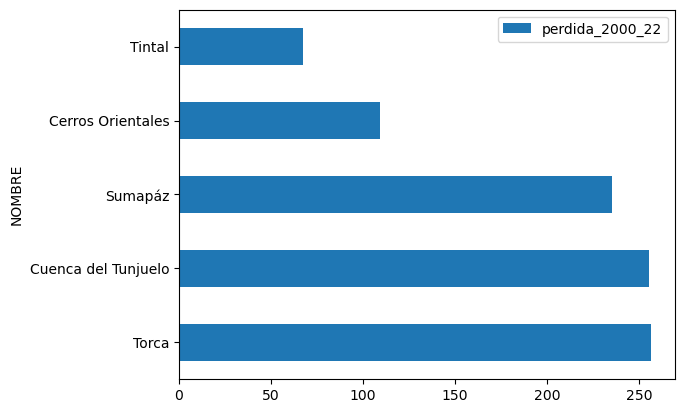

In [29]:
perdida_upls.set_index('NOMBRE').plot(kind='barh')

In [79]:
df2[['NOMBRE', 'tree_cover_22']].sort_values(by='tree_cover_22', ascending=False)

,NOMBRE,tree_cover_22
23,Sumapáz,"13,303.45"
31,Cerros Orientales,"8,879.87"
21,Cuenca del Tunjuelo,"3,722.37"
22,Torca,589.23
26,Rafael Uribe,261.82
24,Britalia,228.84
16,Engativá,184.53
5,Usaquén,162.58
6,Niza,157.16
25,Usme - Entrenubes,153.64


In [84]:
upls[upls['NOMBRE'] == 'Sumapáz'].transpose()

,23
CODIGO_UPL,UPL01
NOMBRE,Sumapáz
ACTO_ADMIN,DEC
NUMERO_ACT,555
FECHA_ACTO,2021-12-29
NORMATIVA,En el marco del Decreto 555 del 29 de diciembr...
VOCACION,Rural
OBSERVACIO,Que mediante Resolución 2050 del 23 de noviemb...
AREA_HA,"78,096.87"
SECTOR,Sector Rural


In [34]:
upls_rurales['AREA_HA'].sum()

138987.10285109997

In [35]:
upls['AREA_HA'].sum()

163636.94097601998

In [39]:
upls_rurales['AREA_HA'].sum()

119607.66098419999

In [1]:
# filepath: /Users/Daniel/Desktop/bosques_bog/bosques-bog/notebooks_de_referencia/bosques_bogota.ipynb
# ...existing code...

import gcsfs 
import geopandas as gpd
import dotenv
dotenv.load_dotenv()

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

# Assuming INPUTS_PATH is defined (e.g., from .env or hardcoded)
INPUTS_PATH = 'gs://material-estatico-sdp/SIMBYP_DATA'

# Automatically generate the full GCS path
POLYGON_PATH = os.path.join(INPUTS_PATH, "area_estudio", "gfw", "area_estudio.geojson")

POLYGON_PATH
import geopandas as gpd
gdf_polygon = gpd.read_file(POLYGON_PATH)

/Users/Daniel/Desktop/bosques_bog/bosques-bog/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
#Read the local shapefile
shp_path = '/Users/Daniel/Desktop/temporal_simbyp/upls.shp'
gdf_polygon = gpd.read_file(shp_path)


#Eliminar las UPLs de Sumapáz y Cuenca del Tunjuelo
gdf = gdf_polygon[gdf_polygon['NOMBRE']!='Sumapáz']
gdf = gdf[gdf['NOMBRE']!='Cuenca del Tunjuelo']
# Reproject to a metric CRS first (example: UTM 18N)
gdf_metric = gdf.to_crs('EPSG:32618')

aggregated = gdf_metric.unary_union
buffered = aggregated.buffer(1000)

gdf_buffered = gpd.GeoDataFrame(geometry=[buffered], crs=gdf_metric.crs)

# Back to WGS84 for the bounding box
gdf_buffered_wgs84 = gdf_buffered.to_crs('EPSG:4326')

bbox = gdf_buffered_wgs84.total_bounds  # [minx, miny, maxx, maxy]

print("Buffered Bounding Box (WGS84):", bbox)

gdf_buffered_wgs84.to_file('/Users/Daniel/Desktop/temporal_simbyp/upls_buffered.shp')

# Create a polygon from the bounding box
from shapely.geometry import box
bbox_poly = box(bbox[0], bbox[1], bbox[2], bbox[3])  # minx, miny, maxx, maxy
gdf_bbox = gpd.GeoDataFrame(geometry=[bbox_poly], crs='EPSG:4326')

# Save the bounding box polygon
gdf_bbox.to_file('/Users/Daniel/Desktop/temporal_simbyp/upl_bbox.shp')



Buffered Bounding Box (WGS84): [-74.23258912   4.45182775 -73.97753134   4.84582416]


/var/folders/wn/vzyjwy2x00q4stf523pr30jw0000gn/T/ipykernel_4933/491921259.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  aggregated = gdf_metric.unary_union


In [43]:
# Reproject to UTM Zone 18N (EPSG:32618) for accurate area calculation in meters
gdf_bbox_utm = gdf_bbox.to_crs('EPSG:32618')

# Calculate the area of the bounding box polygon in square meters
area_m2 = gdf_bbox_utm.geometry.area.iloc[0]

# Convert to square kilometers
area_km2 = area_m2 / 1_000_000

print(f"The area of the bounding box is approximately {area_km2:.2f} km²")

The area of the bounding box is approximately 1232.31 km²


Below is a draft of the **Terms of Reference (ToRs)** for procuring high-resolution satellite imagery to enhance the visualization of Sentinel layers in urban sprawl maps for Bogotá. This draft is tailored to your needs at the Mayor's Office of Bogotá, focusing on urban sprawl monitoring. It assumes a competitive bidding process (e.g., RFP) and includes key sections for clarity.

I've incorporated your requirements: highest commercially available resolution (targeting ~0.3m panchromatic and ~1.2m multispectral, based on current commercial satellites like WorldView-3 or similar from providers like Maxar or Planet Labs), monthly acquisitions, and cloud-free images (defined as <10% cloud cover). The draft is concise yet comprehensive, and you can customize it further (e.g., add specific budget details or legal clauses).

---

# Terms of Reference (ToRs) for Procurement of High-Resolution Satellite Imagery for Urban Sprawl Monitoring in Bogotá

## 1. Introduction and Background
The Mayor's Office of Bogotá is committed to sustainable urban development and environmental monitoring. As part of the urban sprawl analysis project, we require high-resolution satellite imagery to improve the visualization and accuracy of Sentinel-2 layers used in mapping urban expansion. Current Sentinel data provides valuable insights but lacks the detail needed for precise urban feature identification (e.g., buildings, roads, and vegetation changes). This procurement aims to acquire commercial satellite imagery with the highest available resolution to overlay and enhance Sentinel layers, enabling better decision-making for land-use planning and deforestation prevention.

## 2. Objective
To procure high-resolution, cloud-free satellite imagery for Bogotá's urban area, delivered monthly, to support enhanced visualization of urban sprawl maps. The imagery must integrate seamlessly with existing Sentinel-2 data for comparative analysis.

## 3. Scope of Work
The selected vendor must:
- Acquire and deliver satellite imagery covering the entire Bogotá metropolitan area (approximately 1,600 km², with coordinates: [provide bounding box, e.g., -74.5 to -73.7 longitude, 4.0 to 4.8 latitude]).
- Ensure imagery is cloud-free (<10% cloud cover per scene) and acquired monthly (one image per month, ideally mid-month for consistency).
- Provide the highest commercially available resolution: Panchromatic at ≤0.5m (target ≤0.3m) and multispectral (4-band: RGB + NIR) at ≤1.5m (target ≤1.2m).
- Process and deliver imagery in standard formats (e.g., GeoTIFF, orthorectified, with metadata including acquisition date, sensor details, and geolocation accuracy <2m RMSE).
- Integrate imagery with Sentinel-2 layers (e.g., via co-registration or fusion techniques) to create enhanced maps showing urban sprawl changes.
- Provide technical support for 6 months post-delivery, including data validation and any necessary corrections.

## 4. Deliverables
- **Imagery Dataset**: 12 monthly images (for a 12-month contract period), each covering the full AOI, in GeoTIFF format with associated metadata.
- **Enhanced Maps**: 12 composite maps (one per month) fusing the high-resolution imagery with Sentinel-2 layers, delivered as GeoTIFF or interactive web maps (e.g., via QGIS or ArcGIS-compatible formats).
- **Documentation**: A technical report detailing acquisition parameters, processing methods, and integration with Sentinel data. Include quality assurance reports confirming cloud cover, resolution, and geolocation accuracy.
- **Training and Support**: One virtual training session (2 hours) on using the data, plus email/phone support for 6 months.
- **Data Licensing**: Full rights for use by the Mayor's Office, including redistribution for public reports (non-commercial).

## 5. Technical Specifications
- **Resolution**: Highest commercial standard – Panchromatic: ≤0.5m (target ≤0.3m); Multispectral: ≤1.5m (target ≤1.2m).
- **Spectral Bands**: At least 4 bands (Red, Green, Blue, Near-Infrared) for vegetation and urban analysis.
- **Cloud Cover**: <10% per image.
- **Frequency**: Monthly acquisitions (e.g., 15th of each month ±5 days).
- **Geolocation Accuracy**: <2m RMSE (Root Mean Square Error).
- **Format and Projection**: GeoTIFF in WGS84/UTM Zone 18N projection.
- **Off-Nadir Angle**: <20° for minimal distortion.
- **Integration with Sentinel**: Imagery must be co-registered to Sentinel-2 (10m resolution) for overlay, with fusion techniques (e.g., pansharpening) to enhance detail.
- **Data Volume**: Estimated 50-100 GB total for 12 months.

## 6. Timeline
- **Proposal Submission**: 30 days from RFP issuance.
- **Contract Award**: 15 days after evaluation.
- **First Delivery**: Within 30 days of contract signing (first monthly image).
- **Subsequent Deliveries**: Monthly thereafter, with all 12 images delivered within 13 months.
- **Project Completion**: 18 months from contract start.

## 7. Budget
Estimated budget: USD 50,000–100,000 for 12 months (depending on provider and volume). Bidders must provide a detailed cost breakdown, including acquisition, processing, and integration fees. The Mayor's Office reserves the right to negotiate.

## 8. Evaluation Criteria
Proposals will be evaluated based on:
- Technical compliance (40%): Resolution, cloud cover, accuracy, and integration capabilities.
- Experience and References (30%): Proven track record with similar projects (e.g., urban monitoring in Latin America).
- Cost (20%): Value for money.
- Timeline and Support (10%): Delivery schedule and post-delivery services.

## 9. Responsibilities
- **Vendor**: Acquire, process, and deliver imagery; ensure quality; provide support.
- **Mayor's Office**: Provide AOI coordinates, access to Sentinel data for integration, and feedback on deliverables.
- **Oversight**: A technical committee from the Mayor's Office will review samples and final outputs.

## 10. Confidentiality and Intellectual Property
All data and deliverables are confidential. The vendor retains IP for their technology but grants full usage rights to the Mayor's Office.

## 11. Submission Requirements
- Technical proposal detailing methodology, sample imagery, and team expertise.
- Financial proposal with itemized costs.
- References from similar projects.

This ToRs is subject to Colombian procurement laws and may be amended. For questions, contact [Your Contact Information].

---

This draft is ready for use in an RFP. If you need adjustments (e.g., adding specific AOI details, budget caps, or legal clauses), let me know! Note that "highest commercially available" may vary by provider—confirm with vendors like Maxar or Planet for exact specs.